 # Car Price prediction


## **Цели проекта**


> * Прогнозирование стоимости автомобиля по доступным характеристикам
> * Использование алгоритмов ML и DL для нахождения оптимального результата
> * Практическое применение знаний машинного обучения для обработки данных, а также настройки параметров алгортмов

***Поскольку кроме задачи нахождения результата, есть еще задача обучения и построения методики, ноутбук будет построен в виде этапов использования алгоритмов, начиная от самого простого***

# Imports

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-car-price-prediction-part2/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction-part2/train.csv
/kaggle/input/sf-dst-car-price-prediction-part2/test.csv
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099952182.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099760426.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1098602592.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099459442.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1099915820.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1100250106.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1097983236.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1097690708.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1100181932.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1088478624.jpg
/kaggle/input/sf-dst-car-price-prediction-part2/img/img/1094300816.jpg
/kaggle/input/sf-dst-car-price-pre

In [2]:
#аугментации изображений
# !pip install albumentations -q
# !pip install -U albumentations[imgaug]
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru
!pip install pymystem3

     |████████████████████████████████| 55 kB 1.2 MB/s            
     |████████████████████████████████| 8.2 MB 3.3 MB/s            


In [203]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pandas_profiling


from scipy.optimize import minimize
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# visualization
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import seaborn as sns

# tokenizing
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('russian')
import string
import pymorphy2
from nltk.tokenize import RegexpTokenizer
from tqdm.auto import tqdm, trange
from pymystem3 import Mystem

# augumentation
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, GaussianBlur, Rotate
)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.20.3
Tensorflow   : 2.6.2


In [5]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
!pip freeze > requirements.txt

# Internal Functions

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [8]:
# Функция расчета IQR (interquartile range)
def define_IQR(data, column):
    Q25 = data[column].quantile(0.25)
    Q75 = data[column].quantile(0.75)
    IQR = Q75 - Q25
    l_bound = Q25 - 1.5*IQR
    r_bound = Q75 + 1.5*IQR
    
    print('low=', l_bound)
    print('high=', r_bound )

In [10]:
# Функция приведения признаков к IQR (interquartile range)
def cut_IQR(data, column):
    Q25 = data[column].quantile(0.25)
    Q75 = data[column].quantile(0.75)
    IQR = Q75 - Q25
    l_bound = Q25 - 1.5*IQR
    r_bound = Q75 + 1.5*IQR

    data[column] = data[column].apply(lambda x: r_bound if x  >=  r_bound else x)
    data[column] = data[column].apply(lambda x: l_bound if x  <=  l_bound else x)

In [9]:
# Визуализация распреденения призаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [12]:
def preproc_data(df_input):
    '''преобразования данных для использования catboost regressor.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем ненужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    # Нормируем данные (выбираем опцию)
    scaler = StandardScaler()
    # scaler = RobustScaler() # удалает выбросы более IQR
    # scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)

    
    # ################### Clean #################################################### 
    # убираем признаки, которые не будем использовать
    df_output.drop(['vehicle_configuration',], axis = 1, inplace=True)
    
    return df_output

In [13]:
def preproc_data_2(df_input):
    '''используется для улучшения результата с catboost regressor.'''
    
    df_output = df_input.copy()
    
    # ################### Предобработка ################################################################## 
    # убираем ненужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
     
    
    # ################### Feature Engineering ############################################################
    # Создадим бинарный признак ретро для автомобилей до 1990 года
    df_output['retro'] = df_output['production_date'].apply(lambda x: 1 if x < 1998 else 0)
    # Создаем бинарный признак для машин с большим пробегом
    df_output['high_mileage'] = df_output['mileage'].apply(lambda x: 1 if x > 328841 else 0)
    
    # Преобразуем литраж в числовой параметр
    df_output['engine_displacement'] = df_output['engine_displacement'].apply(lambda x: x[:3])
    # Заменим в значениях, где не было числа на 0.0 
    df_output['engine_displacement'] = df_output['engine_displacement'].replace('und','0.0')
    # Заменим значения на числовые 
    df_output['engine_displacement'] = df_output['engine_displacement'].apply(lambda x: float(x))
    # Заменим на мединану
    engine_median = df_output.engine_displacement.median()
    df_output['engine_displacement'] = df_output['engine_displacement'].apply(lambda x: engine_median if x  ==  0.0 else float(x))
    
    # Преобразуем мощность двигателя в числовой параметр
    df_output['engine_power'] = df_output['engine_power'].apply(lambda x: x[:3])
    df_output['engine_power'] = df_output['engine_power'].apply(lambda x: int(x))
    
    # Переведем значения владельцов в числовой формат
    df_output['owners'] = df_output['owners'].apply(lambda x: int(x[0]) if type(x) == str else x)
    df_output['owners'].fillna(3.0, inplace=True)
    
    # Создадим новый признак
    df_output['mileage_per_year'] = df_output.mileage/(2020-df_output.production_date)
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].mode(), inplace=True)
    
    # Обработка выбросов:
    for col in numerical_features:
        cut_IQR(df_output, col)
    
    # Логарифмирование данных
    # df_output['production_date'] = np.log(2021 - df_output['production_date'])
    # df_output['mileage'] = df_output['mileage'].apply(lambda x: np.log(x+1))
    
    # Нормализация данных (выбираем опцию)
    scaler = StandardScaler()
    # scaler = RobustScaler() # ограничивает выбросы до IQR
    # scaler = MinMaxScaler()
    for column in ['model_date', 'engine_displacement','engine_power', 'mileage',
                   'production_date', 'mileage_per_year']:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        
    
    # ################### Categorical Features ############################################################## 
    # Заполняем пропуски
    data['ownership'].fillna('неизвестно', inplace=True)
    
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые не вносят улучшения 
    df_output.drop(['vehicle_configuration'], axis = 1, inplace=True)


    return df_output

In [14]:
def preproc_data_3(df_input):
    '''используем для приготовления данных для simple tabular NN .'''
    
    df_output = df_input.copy()
    
    # Извлекаем нужные признаки из name
    df_output['x_drive'] = df_output['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
    df_output['full_drive'] = df_output['name'].apply(lambda x: 1 if '4WD' in x else 0)
     
    # Удаляем признак name, уменьшая размерность
    df_output.drop(['name'], axis = 1, inplace=True)
    
    df_output = preproc_data_2(df_output)
    
    return df_output

# DATA

In [238]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [238]:
# For kagle
# DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
# train = pd.read_csv(DATA_DIR + 'train.csv')
# test = pd.read_csv(DATA_DIR + 'test.csv')
# sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [239]:
# Заменим названия колонок
train.rename(columns={'bodyType': 'body_type',
                     'brand': 'brand',
                     'color': 'color',
                     'description': 'description',
                     'engineDisplacement': 'engine_displacement',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel_type',
                     'mileage': 'mileage',
                     'modelDate': 'model_date',
                     'model_info': 'model_info',
                     'name': 'name',
                     'numberOfDoors': 'number_of_doors',
                     'price': 'price',
                     'productionDate': 'production_date',
                     'sell_id': 'sell_id',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'vehicle_transmission',
                     'Владельцы': 'owners',
                     'Владение': 'ownership',
                     'ПТС': 'documents',
                     'Привод': 'drive',
                     'Руль': 'drive_side',
                    }, inplace=True)

In [240]:
# Заменим названия колонок
test.rename(columns={'bodyType': 'body_type',
                     'brand': 'brand',
                     'color': 'color',
                     'description': 'description',
                     'engineDisplacement': 'engine_displacement',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel_type',
                     'mileage': 'mileage',
                     'modelDate': 'model_date',
                     'model_info': 'model_info',
                     'name': 'name',
                     'numberOfDoors': 'number_of_doors',
                     'price': 'price',
                     'productionDate': 'production_date',
                     'sell_id': 'sell_id',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'vehicle_transmission',
                     'Владельцы': 'owners',
                     'Владение': 'ownership',
                     'ПТС': 'documents',
                     'Привод': 'drive',
                     'Руль': 'drive_side',
                    }, inplace=True)

In [241]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [97]:
# train.info()

In [98]:
# train.nunique()

In [99]:
# test.info()

In [100]:
# data.info()

### Типы признаков:

* body_type - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engine_displacement - числовой, представленный как текст
* engine_power - числовой, представленный как текст
* fuel_type - категориальный
* mileage - числовой
* model_date - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* number_of_doors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicle_configuration - не используется (комбинация других столбцов)
* vehicle_transmission - категориальный
* owners - категориальный
* ownership - числовой, представленный как текст
* documents - категориальный
* drive - категориальный
* drive_side - категориальный

# Stage 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.


In [101]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [102]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'production_date']]).iterrows():
    query = f"model_info == '{row[0]}' and production_date == {row[1]}"
    predicts.append(data_train.query(query)['price'].median())

# заполним ненайденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# Stage 2: EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [24]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Выводы по pandas.profiling**:
* Наибольшее число пропусков содержит колнка с владением
* Большая корреляция присутствует между признаками mileage, production_date, model_date
* Графики показыват, что распределение на смещено и не является нормальным


In [242]:
# Разделим признаки по типам данных
categorical_features = ['body_type', 'brand', 'color', 'engine_displacement', 'engine_power', 'fuel_type', 
                        'model_info', 'name', 'number_of_doors', 'vehicle_transmission', 'owners', 'ownership', 
                        'documents', 'drive', 'drive_side']

#используем все числовые признаки
numerical_features = ['mileage', 'model_date', 'production_date']

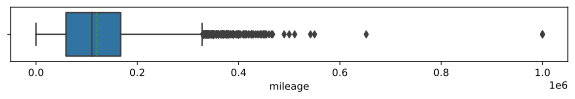

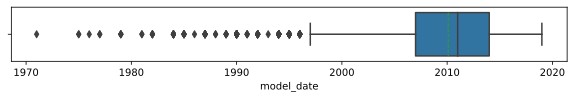

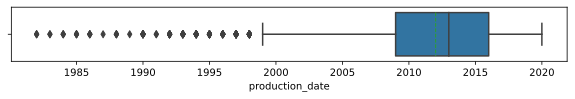

In [243]:
#  Посмотрим на boxplots, на них хорошо видны выбросы
for col in numerical_features:
    plt.figure(figsize=(10,1))
    sns.boxplot(x=data[col], orient='h',showmeans=True, meanline=True,)

### **Вывод**:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.
* Числовые переменные содержат много выбросов. На последующих этапах можно будет их обработать

# Stage 3: Подготовка данных для catboost

In [27]:
# Запускаем первоначальную предобработку и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

mileage  model_date  production_date  sample      price  body_type_0  \
7399 -0.163258    0.716708         0.585318       1  1590000.0            0   
4273 -0.920726    0.532769         0.781128       1  3100000.0            0   
3362 -0.798553    0.532769         0.585318       1  3750000.0            0   
2794  0.056651    0.164891        -0.197919       1  1990000.0            0   
5378  0.349864    0.532769         0.585318       1  1285000.0            0   
5902 -0.617739    0.348830         0.193700       1  3399999.0            0   
1454 -0.825847    0.348830         0.585318       0        0.0            0   
2476  0.649186   -0.570865        -0.785347       1   700000.0            0   
743  -0.004435   -0.570865        -0.393728       0        0.0            0   
1168 -1.030680    0.348830         0.389509       0        0.0            0   

      body_type_1  body_type_2  body_type_3  body_type_4  ...  ownership_177  \
7399            1            0            0            0  ...              0   
4273            1            0            0            0  ...              0   
3362            0            0            0            0  ...              0   
2794            0            0            0            0  ...              0   
5378            0            0            0            0  ...              0   
5902            0            0            0            0  ...              0   
1454            0            0            0            0  ...              0   
2476            0            0            0            0  ...              0   
743             0            0            0            0  ...              0   
1168            1            0            0            0  ...              0   

      ownership_178  ownership_179  documents_0  documents_1  drive_0  \
7399              0              0            0            1        0   
4273              0              0            0            1        0   
3362              0              0            0            1        0   
2794              0              0            0            1        0   
5378              0              0            0            1        0   
5902              0              0            0            1        0   
1454              0              0            0            1        0   
2476              0              0            1            0        1   
743               0              0            0            1        1   
1168              0              0            0            1        0   

      drive_1  drive_2  drive_side_0  drive_side_1  
7399        0        1             1             0  
4273        0        1             1             0  
3362        0        1             1             0  
2794        0        1             1             0  
5378        0        1             1             0  
5902        0        1             1             0  
1454        0        1             1             0  
2476        0        0             1             0  
743         0        0             1             0  
1168        0        1             1             0  

[10 rows x 1545 columns]

#### **Split data**

In [28]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

# Stage 4: CatBoostRegressor

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# # Запустим  gridsearch,  чтобы найти оптимальные гиперпараметры настройки нашего регрессора
model_test = CatBoostRegressor()
parameters = {'depth' : [8, 9,10],
              'learning_rate' : [0.1, 0.2],
              'iterations'    : [8000, 9000]
              }

grid = GridSearchCV(estimator=model_test, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train, verbose_eval=500)

Методом экспериментов удалось еще немного точнее определить оптимальные параметры. Минус GridSearch в том, что занимает много времени, но основные направления помогло найти.

In [30]:
model = CatBoostRegressor(iterations = 10000,
                          depth=9,
                          learning_rate = 0.015,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
#                           task_type='GPU',                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.9929173	test: 1.0171802	best: 1.0171802 (0)	total: 89.4ms	remaining: 14m 53s
500:	learn: 0.2113922	test: 0.2230888	best: 0.2230888 (500)	total: 8.44s	remaining: 2m 40s
1000:	learn: 0.1671603	test: 0.1820090	best: 0.1820090 (1000)	total: 16.8s	remaining: 2m 30s
1500:	learn: 0.1464323	test: 0.1626871	best: 0.1626871 (1500)	total: 25s	remaining: 2m 21s
2000:	learn: 0.1360380	test: 0.1540128	best: 0.1540128 (2000)	total: 33.2s	remaining: 2m 12s
2500:	learn: 0.1261273	test: 0.1466191	best: 0.1466191 (2500)	total: 41.8s	remaining: 2m 5s
3000:	learn: 0.1180020	test: 0.1406688	best: 0.1406688 (3000)	total: 50.1s	remaining: 1m 56s
3500:	learn: 0.1124618	test: 0.1367516	best: 0.1367516 (3500)	total: 58.3s	remaining: 1m 48s
4000:	learn: 0.1075942	test: 0.1336966	best: 0.1336966 (4000)	total: 1m 6s	remaining: 1m 39s
4500:	learn: 0.1030614	test: 0.1316707	best: 0.1316707 (4500)	total: 1m 14s	remaining: 1m 31s
5000:	learn: 0.0987284	test: 0.1298508	best: 0.1298508 (5000)	total: 1m 23s	re

In [31]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.43%


#### **Результат**: 
Это гораздо лучше, чем в наивной модели. После дополнительного подбора гиперпараметров удалось уменьшить ошибку до 12.43%. Наиболее влиятельным было изменение learning rate. Оптимальный вариант для данной модели: 0.015 В следующем этапе попробую расширить преобразования данных и посмотреть, насколько удастся улучшить результат

# Stage 5: CatBoostRegressor после дополнительной обработки данных

#### **Дополнительная обработка и создание новых признаков**
Используя знания о значительных выбросах, стоит создать новый признаки, объединив данные за пределами IQR. Посмотрим на границы IQR

In [244]:
define_IQR(data, 'production_date')

low= 1998.5
high= 2026.5


In [245]:
define_IQR(data, 'mileage')

low= -102511.0
high= 328841.0


Новые признаки будут добавлены в preproc_data_2

In [246]:
# # Let's see missing values
# ig, ax = plt.subplots(figsize=(20,8))
# sns_heatmap = sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [247]:
# В признаке ownership отсутствует слишком большое количество значений в признаке владения
data['ownership'].isna().value_counts()

True     5418
False    2935
Name: ownership, dtype: int64

Заменим на "неизвестно". Пока это категориальный признак

#### **Итоги преобразований** 
Добавим в функцию преобразований следущее:
* Ограничим выбросы до IQR
* Создадим новые числовые переменные `retro`и `high_mileage`
* Заполним пропуски в  ownership
* Преобразуем объем двигателя и мощность в числовыю переменные

In [248]:
# Обновим типы признаков
categorical_features = ['body_type', 'brand', 'color', 'fuel_type', 'name', 'ownership','owners',
                        'model_info','number_of_doors', 'vehicle_transmission', 
                        'documents', 'drive', 'drive_side']

numerical_features = ['mileage', 'model_date', 'production_date', 'engine_displacement','engine_power',
                         'mileage_per_year' ,]
    
binary_features = ['retro', 'high_mileage']

In [249]:
# Запускаем и проверяем, что получилось
df_preproc_2 = preproc_data_2(data)
df_preproc_2.sample(10)

engine_displacement  engine_power   mileage  model_date  \
6009            -0.792191     -0.630657 -1.387262    1.373703   
5828            -0.792191     -0.414366 -0.648662    0.763426   
1695            -0.792191     -1.042641  0.510480   -1.067408   
5626             0.985245      0.296306  0.782138   -1.067408   
4620            -0.792191     -0.692455 -1.289285    0.966852   
467              1.985052      1.470459  1.039634   -2.796528   
3456             0.874155     -0.022981 -0.256856    0.153148   
1442             0.318706     -0.187775  0.325084   -0.660556   
4730             0.318706     -0.022981 -1.022262    0.966852   
1490             0.207617     -0.022981 -0.569714    1.373703   

      production_date  sample      price  retro  high_mileage  \
6009         1.439884       1  3148000.0      0             0   
5828         0.814068       1  3675000.0      0             0   
1695        -1.271986       1   385000.0      0             0   
5626        -1.063380       1   705000.0      0             0   
4620         1.231279       1  2057000.0      0             0   
467         -2.836526       0        0.0      1             0   
3456         0.605463       1  2800000.0      0             0   
1442        -0.854775       0        0.0      0             0   
4730         1.022673       1  3699000.0      0             0   
1490         1.231279       0        0.0      0             0   

      mileage_per_year  ...  vehicle_transmission_1  vehicle_transmission_2  \
6009         -0.598401  ...                       0                       0   
5828          0.177117  ...                       0                       0   
1695         -0.618749  ...                       0                       0   
5626         -0.280142  ...                       0                       0   
4620         -0.862243  ...                       0                       0   
467          -1.073181  ...                       0                       0   
3456          0.535644  ...                       0                       0   
1442         -0.524924  ...                       0                       0   
4730         -0.356490  ...                       0                       0   
1490          2.402885  ...                       0                       0   

      vehicle_transmission_3  documents_0  documents_1  drive_0  drive_1  \
6009                       0            0            1        0        0   
5828                       0            0            1        1        0   
1695                       0            1            0        1        0   
5626                       0            0            1        0        0   
4620                       0            0            1        0        0   
467                        0            0            1        1        0   
3456                       0            0            1        0        0   
1442                       0            0            1        0        0   
4730                       0            0            1        0        0   
1490                       0            0            1        0        0   

      drive_2  drive_side_0  drive_side_1  
6009        1             1             0  
5828        0             1             0  
1695        0             1             0  
5626        1             1             0  
4620        1             1             0  
467         0             1             0  
3456        1             1             0  
1442        1             1             0  
4730        1             1             0  
1490        1             1             0  

[10 rows x 1347 columns]

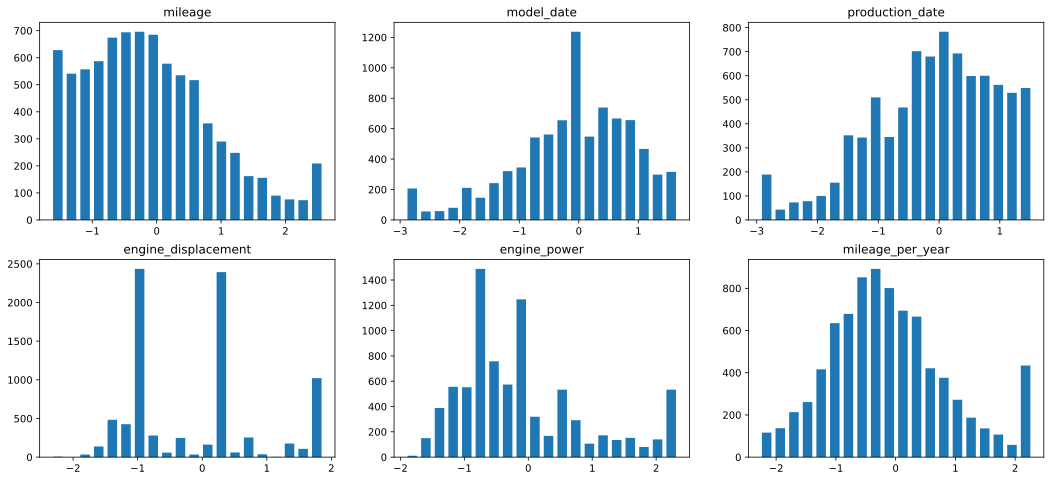

In [250]:
# Посмотрим на графики после преобразований
visualize_distributions({
    'mileage': df_preproc_2['mileage'],
    'model_date': df_preproc_2['model_date'],
    'production_date': df_preproc_2['production_date'],
    'engine_displacement': df_preproc_2['engine_displacement'],
    'engine_power': df_preproc_2['engine_power'],
    'mileage_per_year': df_preproc_2['mileage_per_year'],
})

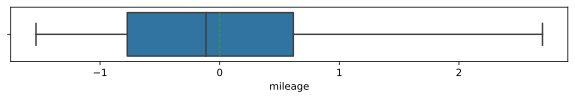

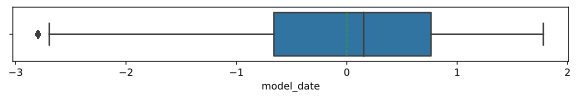

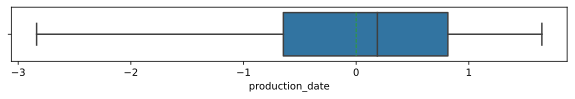

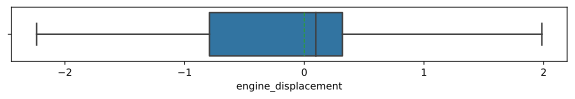

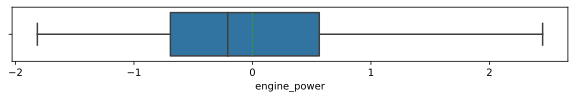

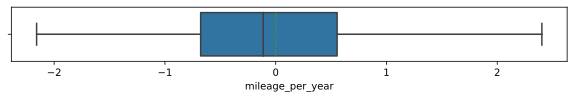

In [251]:
#  Boxplots:
for col in numerical_features:
    plt.figure(figsize=(10,1))
    sns.boxplot(x=df_preproc_2[col], orient='h',showmeans=True, meanline=True,)

Поскольку несколько категориальных признаков было преобразовано в числовые, количество колонок уменьшилось. Выбросов нет. Смещение осталось. Эксперименты по дальнейшей нормализации приводили к ухудшению результата

In [252]:
# Выделим тестовую часть
train_data_2 = df_preproc_2.query('sample == 1').drop(['sample'], axis=1)
test_data_2 = df_preproc_2.query('sample == 0').drop(['sample'], axis=1)

y = train_data_2.price.values     # наш таргет
X = train_data_2.drop(['price'], axis=1)
X_sub = test_data_2.drop(['price'], axis=1)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

Добавим логарифмирование таргета

In [254]:
# Используем уже настроенную модель
model_cat = CatBoostRegressor(iterations = 10000,
                          depth=6,
                          learning_rate = 0.015,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
#                           task_type='GPU',
                         )
model_cat.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0421458	test: 0.0422104	best: 0.0422104 (0)	total: 8.99ms	remaining: 1m 29s
500:	learn: 0.0098678	test: 0.0096356	best: 0.0096356 (500)	total: 3.19s	remaining: 1m
1000:	learn: 0.0089912	test: 0.0090026	best: 0.0090026 (999)	total: 5.97s	remaining: 53.6s
1500:	learn: 0.0083757	test: 0.0086226	best: 0.0086226 (1500)	total: 8.39s	remaining: 47.5s
2000:	learn: 0.0079460	test: 0.0083713	best: 0.0083712 (1996)	total: 10.9s	remaining: 43.5s
2500:	learn: 0.0076486	test: 0.0082399	best: 0.0082394 (2498)	total: 13.4s	remaining: 40.1s
3000:	learn: 0.0074166	test: 0.0081392	best: 0.0081388 (2998)	total: 16.2s	remaining: 37.7s
3500:	learn: 0.0071975	test: 0.0080346	best: 0.0080346 (3500)	total: 18.6s	remaining: 34.5s
4000:	learn: 0.0070214	test: 0.0079665	best: 0.0079665 (4000)	total: 21.1s	remaining: 31.6s
4500:	learn: 0.0068714	test: 0.0079187	best: 0.0079187 (4500)	total: 23.5s	remaining: 28.7s
5000:	learn: 0.0067175	test: 0.0078772	best: 0.0078772 (5000)	total: 26.3s	remaining: 26.3

In [255]:
test_predict_catboost = np.exp(model_cat.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.32%


In [256]:
# Сохранаем submission
sub_predict_catboost = np.exp(model_cat.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

#### **Итоги по CatBoostRegression**: 

Есть прогресс. После преобразований удалось уменьшить ошибку до 11.32%. Первоначально я хотел удалить один из сильно скоррелированных признаков, но результат ухудшился. Также удаление поля `name` отрицательно влияло на результат. Логарифмирование признаков тоже отменил, оставил только логарифмирование таргета 


> * Создание дополнительных признаков из выбросов улучшило результат
> * Не смотря на большое количество пропусков в признаке владения, удаление этого признака ухудшало результат. Так же, как заполнение его наиболее встречающимися значениями. Поскольку catboost хорошо работает с категориальными значениями, заполнение значением "неизвестно" сделало свою работу
> * Создание новых числовых переменных `retro`и `high_mileage` положительно повлияло на резльтат
> * Преобразования объема двигателя и мощности в числовые переменные дало нужный эффект
> * Помогли настройки гиперпараметров модели

# Stage 6: Tabular Neural Network (Model NN1)

#### **Преобразования для нейронной сети**

Из `name` были выделены два новые признака, а само `name` было удалено. Экперименты с логарфмированием данных не привели к положительному результату

In [115]:
# Обновим типы признаков
categorical_features = ['body_type', 'brand', 'color', 'fuel_type', 'ownership','owners',
                        'model_info','number_of_doors', 'vehicle_transmission', 
                        'documents', 'drive', 'drive_side']

numerical_features = ['mileage', 'model_date', 'production_date', 'engine_displacement','engine_power',
                         'mileage_per_year' ,]
    
binary_features = ['retro', 'high_mileage']

In [116]:
# Запускаем и проверяем, что получилось
df_preproc_3 = preproc_data_3(data)
df_preproc_3.sample(10)

engine_displacement  engine_power   mileage  model_date  \
1493             0.318706      0.069715  1.168382    0.560000   
8218            -0.236742     -0.342269  1.297130   -0.457130   
6273             0.318706     -0.022981 -1.181266    1.170278   
809              0.318706      1.542556 -0.698461    1.170278   
3880             0.096527     -0.486463 -0.144846   -0.050278   
2958             1.985052      1.892742  0.498893   -0.863982   
7868            -0.681101     -0.836649  0.952085   -0.457130   
3299             0.318706      1.336564 -0.506627    0.356574   
5508             1.651783      1.017277  0.910886   -1.067408   
5243            -0.792191     -1.145636  1.496431   -1.270834   

      production_date  sample      price  x_drive  full_drive  retro  ...  \
1493         0.396857       0        0.0        1           1      0  ...   
8218        -0.437564       1   799000.0        0           0      0  ...   
6273         1.231279       1  3280000.0        1           1      0  ...   
809          1.022673       0        0.0        0           1      0  ...   
3880         0.188252       1  1100000.0        0           1      0  ...   
2958        -1.063380       1   630000.0        0           1      0  ...   
7868        -0.228959       1   900000.0        0           1      0  ...   
3299         0.188252       1  2200000.0        0           1      0  ...   
5508        -1.271986       1   780000.0        0           1      0  ...   
5243        -1.480591       1   400000.0        0           0      0  ...   

      vehicle_transmission_1  vehicle_transmission_2  vehicle_transmission_3  \
1493                       0                       0                       0   
8218                       0                       0                       0   
6273                       0                       0                       0   
809                        0                       0                       0   
3880                       0                       0                       1   
2958                       0                       0                       0   
7868                       0                       0                       0   
3299                       0                       0                       0   
5508                       0                       0                       0   
5243                       1                       0                       0   

      documents_0  documents_1  drive_0  drive_1  drive_2  drive_side_0  \
1493            0            1        0        0        1             1   
8218            0            1        1        0        0             1   
6273            0            1        0        0        1             1   
809             0            1        0        0        1             1   
3880            1            0        0        0        1             1   
2958            1            0        0        0        1             1   
7868            0            1        0        0        1             1   
3299            0            1        0        0        1             1   
5508            0            1        0        0        1             1   
5243            0            1        0        1        0             1   

      drive_side_1  
1493             0  
8218             0  
6273             0  
809              0  
3880             0  
2958             0  
7868             0  
3299             0  
5508             0  
5243             0  

[10 rows x 373 columns]

In [117]:
# Выделим тестовую часть
train_data_3 = df_preproc_3.query('sample == 1').drop(['sample'], axis=1)
test_data_3 = df_preproc_3.query('sample == 0').drop(['sample'], axis=1)

y = train_data_3.price.values     # наш таргет
X = train_data_3.drop(['price'], axis=1)
X_sub = test_data_3.drop(['price'], axis=1)

 ### ***Это наш преобразованный табличный датасет***

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

#### **Запускаем модель**

In [119]:
tf.keras.backend.clear_session()

In [120]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], 
                  activation="sigmoid",
#                   activation='relu',
                  kernel_regularizer=regularizers.l2(l2=1e-6),
                  bias_regularizer=regularizers.l2(l2=1e-6),
                 ))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l2(l2=1e-5),
                  bias_regularizer=regularizers.l2(l2=1e-5),
                  activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l2(l2=0.00001), 
                  bias_regularizer=regularizers.l2(l2=0.00001),
                  activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(32, kernel_regularizer=regularizers.l2(l2=0.001),
                  bias_regularizer=regularizers.l2(l2=0.001),
                  activation="relu"))
# model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

In [121]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               190464    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8

In [123]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [124]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [125]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
12/12 [==============================] - 1s 21ms/step - loss: 100.0332 - MAPE: 99.9944 - val_loss: 99.9666 - val_MAPE: 99.9485
Epoch 2/500
12/12 [==============================] - 0s 6ms/step - loss: 99.5717 - MAPE: 99.5543 - val_loss: 97.9191 - val_MAPE: 97.8929
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 92.6954 - MAPE: 92.6495 - val_loss: 77.0956 - val_MAPE: 77.0103
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 60.7031 - MAPE: 60.5707 - val_loss: 56.3500 - val_MAPE: 56.1591
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 53.3062 - MAPE: 53.1273 - val_loss: 50.8894 - val_MAPE: 50.7341
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 51.1605 - MAPE: 51.0042 - val_loss: 49.6543 - val_MAPE: 49.4876
Epoch 7/500
12/12 [==============================] - 0s 5ms/step - loss: 49.8946 - MAPE: 49.7269 - val_loss: 48.3195 - val_MAPE: 48.1529
Epoch 8/500
12/12 [====================

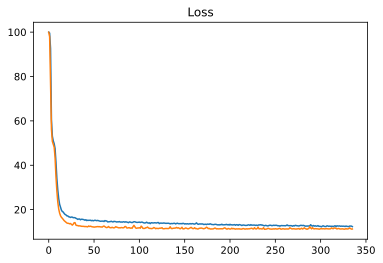

In [126]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [127]:
model.load_weights('working/best_model.hdf5')
model.save('working/nn_1.hdf5')
#  For kagle
# model.load_weights('../working/best_model.hdf5')
# model.save('../working/nn_1.hdf5')

In [128]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.26%


In [129]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

#### **Итоги по 6 этапу**: 
* Экпериментировал с функциями активации: tanh, relu, elu, sigmoid. На данным этапе оставил sigmoid на первом полносвязном сле
* Экспериментировал с регуляторами и значением L2. l2=1e-6l2=1e-6 на первом полносвязном слое, увеличивая знаяения на последующих. Также добавил bias_regularizerbias_regularizer
* Пробовал различные optimizers (Adamax, SGD, Adam). Adamax давал хороший результат, но кривая опускалась ниже на более поздних операциях, чем при использовнии Adam, поэтому окончательно оставил Adam

*Я еще несколько раз возвращался к этому этапу, чтобы пробовать изменить табличную сеть, беря во внимание ее последующую совместную работу с иными сетями*

# Step 7: NLP + Multiple Inputs (Model NN2)

In [29]:
# Посмотрим, какая информация хранится в описании
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [30]:
# TOKENIZER
# Зададим максимально количество слов (most frequent)
MAX_WORDS = 100000
# И маскимальную длину секвенции
MAX_SEQUENCE_LENGTH = 500

In [31]:
# split данных по индексам
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [32]:
text_train

7320    Требуется замена форсунок и рулевой рейки( рем...
8037    Очень красивый, практически новый автомобиль. ...
4681    Внимание! Только для клиентов AVILON Автомобил...
6014    В шикарном состоянии, полностью обслужен,делат...
3649    Состояние отличное\nОдин владелец\nДоводчики н...
                              ...                        
5443    ИДЕАЛЬНОЕ СОСТОЯНИЕ...!!! НИ ОДНОЙ КРАШЕННОЙ Д...
6862    РОЛЬФ Премиум – крупнейший официальный дилер М...
6897    S-Linе Аlkantara в хорошем состоянии, сидeния ...
7061    Продаётся собственником. В ПТС я один хозяин.\...
2531    «Inchcape Certified-  Первый международный офи...
Name: description, Length: 5679, dtype: object

In [33]:
text_test

5951    ID: 38742\n«МБ Измайлово»  –  официальный диле...
7646    Продаю свой авто в связи с крайне редким испол...
3123    Автомобиль в идеальном состоянии не битый, не ...
7597    На отличном ходу. В хорошем состоянии для 12 л...
7740    Внимание! Только для клиентов AVILON Автомобил...
                              ...                        
8134    [Smart]\n\n\nАвтомобиль соответствует Программ...
4102    Автомобиль в очень хорошем состояние, недостат...
5020    Турбину чинить Ограничений нет !!!!!!!!!Двигат...
2535    Автомобиль в отличном состоянии. Пишите, звоните.
6299    За машину не стыдно, только сделано Т.О. Все в...
Name: description, Length: 1003, dtype: object

In [34]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.83 s, sys: 6.17 ms, total: 1.84 s
Wall time: 1.84 s


In [35]:
# Выведем словарь после токенизации
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [36]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 500) (1003, 500) (1671, 500)
CPU times: user 1.96 s, sys: 28 ms, total: 1.99 s
Wall time: 1.99 s


In [37]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

#### **RNN NLP**
собираем рекурентную сеть для обработки текста

In [39]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

#### **MLP**
Добавляем табличную сеть из прошлого шага

In [40]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], 
                  activation="sigmoid",
                  kernel_regularizer=regularizers.l2(l2=1e-6)
                 ))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, kernel_regularizer=regularizers.l2(l2=1e-6),
                  activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, kernel_regularizer=regularizers.l2(l2=0.00001), 
                  activation="relu"))
model_mlp.add(L.Dropout(0.25))
model_mlp.add(L.Dense(32, kernel_regularizer=regularizers.l2(l2=0.001), 
                  activation="relu"))
# model.add(L.Dropout(0.25))
model_mlp.add(L.Dense(1, activation="linear"))

 #### **Multiple Inputs NN**
 Соединяем в одну сеть

In [41]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

# Два входа из RNN и MLP, а в конце один выход - голова
model_multi_1 = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [42]:
model_multi_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_2_input (InputLayer)      [(None, 371)]        0                                            
__________________________________________________________________________________________________
seq_description (InputLayer)    [(None, 500)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          190464      dense_2_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 500)     19796000    seq_description[0][0]            
______________________________________________________________________________________________

#### **Fit**

In [43]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_multi_1.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [45]:
checkpoint = ModelCheckpoint('working/best_model_multi_1.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
# For kagle
# checkpoint = ModelCheckpoint('../working/best_model_multi_1.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

Данные X_train, Y_train берем с этапа приготовления для табличной сети (этап 6)

In [46]:
history = model_multi_1.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

2022-02-07 19:35:40.154816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
12/12 [==============================] - 236s 19s/step - loss: 100.0228 - MAPE: 99.9989 - val_loss: 99.9926 - val_MAPE: 99.9899
Epoch 2/500
12/12 [==============================] - 221s 18s/step - loss: 99.9552 - MAPE: 99.9526 - val_loss: 99.8154 - val_MAPE: 99.8120
Epoch 3/500
12/12 [==============================] - 221s 18s/step - loss: 92.0375 - MAPE: 92.0226 - val_loss: 53.5739 - val_MAPE: 53.5154
Epoch 4/500
12/12 [==============================] - 219s 18s/step - loss: 55.7735 - MAPE: 55.7161 - val_loss: 48.4412 - val_MAPE: 48.3841
Epoch 5/500
12/12 [==============================] - 220s 18s/step - loss: 46.5292 - MAPE: 46.4648 - val_loss: 38.8640 - val_MAPE: 38.7929
Epoch 6/500
12/12 [==============================] - 222s 18s/step - loss: 36.0929 - MAPE: 36.0121 - val_loss: 28.8560 - val_MAPE: 28.7633
Epoch 7/500
12/12 [==============================] - 222s 18s/step - loss: 28.5049 - MAPE: 28.4078 - val_loss: 22.6414 - val_MAPE: 22.5381
Epoch 8/500
12/12 [=======

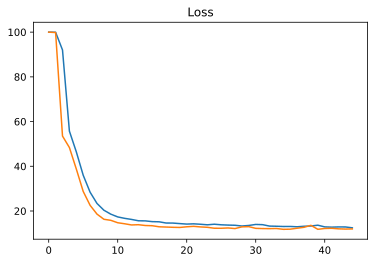

In [47]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [49]:
model_multi_1.load_weights('working/best_model_multi_1.hdf5')
model_multi_1.save('working/nn_multi_1.hdf5')
# For kagle:
# model_multi_1.load_weights('../working/best_model_multi_1.hdf5')
# model_multi_1.save('../working/nn_multi_1.hdf5')

In [50]:
test_predict_nn2 = model_multi_1.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.99%


In [51]:
sub_predict_nn2 = model_multi_1.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

#### **Итоги по 7 этапу**: 
* Добавление сети NLP помогло использовать поле с описанием, но пока результат ухудшается. Нужно очистить текст, чем и займусь на следующем этапе

# Stage 8:  Улучшаем NLP (Model NN3)

In [130]:
# Еще раз посмотрим на пример поля с описанием
data.description[6]

'Внимание! Только для клиентов AVILON Автомобили с пробегом мы предлагаем специальную кредитную программу «Гарантия минимального ежемесячного платежа».\nУсловия кредитования:\n• Первоначальный взнос от 30%.\n• Размер процентной ставки после снижения/перерасчета в конце срока кредита 9,9%.\n• Срок кредита – до 72 месяцев (до 6 лет).\n\nУвеличенная дополнительная скидка:\n1. До 150 000р. при обмене своего автомобиля на наш по системе trade-in\n2. До 100 000р. при оформлении кредита по сниженной ставки от банка-партнёра и полиса КАСКО\n\nВсе скидки и спецпредложения СУММИРУЮТСЯ!\n\nАвтомобиль Audi Q7 от AVILON Автомобили с пробегом – это: \n•\tОбслуживание и предпродажная подготовка только на сертифицированных сервисных станциях с предоставлением официальной диагностики. \n•\tОбязательная юридическая проверка автомобиля, что обеспечивает полную прозрачность сервисной истории и исключает наличие финансового обременения.\n\nКупи или продай любой авто официально в AVILON Автомобили с пробего

Здесь достаточно много различной информации. Попробуем очистить текст для того, чтобы его можно было векторизировать

#### **Stop-words, digits and punctuation**

In [132]:
# Приведем величину букв к одинаковой форме
data.description = data.description.apply(lambda x: x.lower())

In [133]:
# Создадим функцию для удаления цифр
def stop_digits(word):
    return ''.join([x if not x.isdigit() else ' ' for x in word])

In [134]:
data['description_prep'] = [stop_digits(text) for text in tqdm(data['description'])]

  0%|          | 0/8353 [00:00<?, ?it/s]

In [135]:
# Проверим, что цифры удалены
data.description_prep[0]

'всем привет!\n\nпродам эксклюзивный проект     универсал    te-   sportline\n\nмодель    .        te-  \nдвигатель    .   \nтрансмиссия    .   \nцвет кузова     (черный)\nотделка салона     (кожа черная / "антрацит")\n\nопции:\n    автоматическая блокировка дифференциала (asd)\n    индикатор внешней температуры\n    спортивные сиденья спереди\n    спортивное рулевое колесо с отделкой из кожи (диаметр     мм) и кожаный рычаг кпп\n    подушка безопасности для водителя и переднего пассажира\n    дополнительный бардачок в вещевом отсеке спереди\n    люк с электроприводом и устройством подъёма\n    автоматическая коробка передач, напольное исполнение\n    темпомат (круиз-контроль)\n    автоматическая антенна\n    двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n    складной подлокотник спереди\n    кондиционер behr и электрические стеклоподъемники передних и задних дверей\n    атермальные боковые и заднее стекла, заднее стекло с подогревом (esg)\n    спорт

In [136]:
# Проведем предварительную токенизацию
%time
data['description_prep'] = data['description_prep'].apply(word_tokenize)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [137]:
# Посмотрим на измененное поле описания
data.description_prep[0]

['всем',
 'привет',
 '!',
 'продам',
 'эксклюзивный',
 'проект',
 'универсал',
 'te-',
 'sportline',
 'модель',
 '.',
 'te-',
 'двигатель',
 '.',
 'трансмиссия',
 '.',
 'цвет',
 'кузова',
 '(',
 'черный',
 ')',
 'отделка',
 'салона',
 '(',
 'кожа',
 'черная',
 '/',
 '``',
 'антрацит',
 "''",
 ')',
 'опции',
 ':',
 'автоматическая',
 'блокировка',
 'дифференциала',
 '(',
 'asd',
 ')',
 'индикатор',
 'внешней',
 'температуры',
 'спортивные',
 'сиденья',
 'спереди',
 'спортивное',
 'рулевое',
 'колесо',
 'с',
 'отделкой',
 'из',
 'кожи',
 '(',
 'диаметр',
 'мм',
 ')',
 'и',
 'кожаный',
 'рычаг',
 'кпп',
 'подушка',
 'безопасности',
 'для',
 'водителя',
 'и',
 'переднего',
 'пассажира',
 'дополнительный',
 'бардачок',
 'в',
 'вещевом',
 'отсеке',
 'спереди',
 'люк',
 'с',
 'электроприводом',
 'и',
 'устройством',
 'подъёма',
 'автоматическая',
 'коробка',
 'передач',
 ',',
 'напольное',
 'исполнение',
 'темпомат',
 '(',
 'круиз-контроль',
 ')',
 'автоматическая',
 'антенна',
 'двойные',
 '

In [138]:
# Добавим русские стоп-слова
stop_words = stopwords.words('russian')

In [139]:
# Вручную допишем слова, которые не несут смысла в нашем тексте
additional_words = ['это','нам','все','для','т.д.', 'т', 'д','д','мм','e','др','кто-то','л',]
stop_words.extend(additional_words)

In [140]:
# Добавим пунктуацию для удаления из текста
punctuations = list(string.punctuation)

In [141]:
# Так же, как и со словами, можно вручную добавить ненужные знаки
additional_symbols = ['*', '–', '•','.','#','[','«','»','•','[','``',"''",'``',"''",'..', '“','”','∙','—',',','``',
                    ')','.'')','•','.','...','。',]
punctuations.extend(additional_symbols)

In [142]:
total_stop = stop_words+punctuations

In [143]:
# Удалим лишние слова и знаки из нашего текста
for row in data.description_prep:
    for word in row:
        if word not in total_stop:
            word = word
        else:
            row.remove(word)

In [144]:
# Проверяем, что получилось
data.description_prep[0]

['всем',
 'привет',
 'продам',
 'эксклюзивный',
 'проект',
 'универсал',
 'te-',
 'sportline',
 'модель',
 'te-',
 'двигатель',
 'трансмиссия',
 'цвет',
 'кузова',
 'черный',
 'отделка',
 'салона',
 'кожа',
 'черная',
 'антрацит',
 'опции',
 'автоматическая',
 'блокировка',
 'дифференциала',
 'asd',
 'индикатор',
 'внешней',
 'температуры',
 'спортивные',
 'сиденья',
 'спереди',
 'спортивное',
 'рулевое',
 'колесо',
 'отделкой',
 'кожи',
 'диаметр',
 'кожаный',
 'рычаг',
 'кпп',
 'подушка',
 'безопасности',
 'водителя',
 'переднего',
 'пассажира',
 'дополнительный',
 'бардачок',
 'вещевом',
 'отсеке',
 'спереди',
 'люк',
 'электроприводом',
 'устройством',
 'подъёма',
 'автоматическая',
 'коробка',
 'передач',
 'напольное',
 'исполнение',
 'темпомат',
 'круиз-контроль',
 'автоматическая',
 'антенна',
 'двойные',
 'занавески',
 'багажного',
 'пространства',
 'пасажирского',
 'отсека',
 'сетка/шторка',
 'складной',
 'подлокотник',
 'спереди',
 'кондиционер',
 'behr',
 'электрические',
 '

In [145]:
# Соединяем разбитые на элементы составляющие поля с описанием
data['description_prep'] = data['description_prep'].apply(lambda cell: ' '.join(c for c in cell))

In [146]:
# Проверяем
data['description_prep'][0]

'всем привет продам эксклюзивный проект универсал te- sportline модель te- двигатель трансмиссия цвет кузова черный отделка салона кожа черная антрацит опции автоматическая блокировка дифференциала asd индикатор внешней температуры спортивные сиденья спереди спортивное рулевое колесо отделкой кожи диаметр кожаный рычаг кпп подушка безопасности водителя переднего пассажира дополнительный бардачок вещевом отсеке спереди люк электроприводом устройством подъёма автоматическая коробка передач напольное исполнение темпомат круиз-контроль автоматическая антенна двойные занавески багажного пространства пасажирского отсека сетка/шторка складной подлокотник спереди кондиционер behr электрические стеклоподъемники передних задних дверей атермальные боковые заднее стекла заднее стекло подогревом esg спортивная подвеска акб увеличенной мощности установленные сзади динамики электрообогрев передних кресел исполнение sportline коды дополнительно установленные опции внутреннее салонное зеркало автоматич

#### **Lemmatizing the text**

Приведем похожие слова к одной форме. Это поможет сгруппировать похожие слова различных падежей

In [147]:
mystem = Mystem()

description_prep_lem = []
for word in tqdm(data['description_prep']):
    try:
        word_lem = mystem.lemmatize(word)
        tokens = [token for token in word_lem if token != ' ' and token not in total_stop]
        word = " ".join(tokens)
        description_prep_lem.append(word)
    except Exception as e:
        print(e)
    
data['description_prep_lem'] = description_prep_lem

  0%|          | 0/8353 [00:00<?, ?it/s]

In [148]:
data['description_prep_lem'][0]

'привет продавать эксклюзивный проект универсал te -  sportline модель te -  двигатель трансмиссия цвет кузов черный отделка салон кожа черный антрацит опция автоматический блокировка дифференциал asd индикатор внешний температура спортивный сидение спереди спортивный рулевой колесо отделка кожа диаметр кожаный рычаг кпп подушка безопасность водитель передний пассажир дополнительный бардачок вещевой отсек спереди люк электропривод устройство подъем автоматический коробка передача напольный исполнение темпомат круиз контроль автоматический антенна двойной занавеска багажный пространство пасажирский отсек сетка шторка складной подлокотник спереди кондиционер behr электрический стеклоподъемник передний задний дверь атермальный боковой задний стекло задний стекло подогрев esg спортивный подвеска акб увеличивать мощность устанавливать сзади динамика электрообогрев передний кресло исполнение sportline код дополнительно установленный опция внутренний салонный зеркало автоматический изменение 

In [149]:
def final_clean(text):
    for word in punctuations:
        text = text.replace(word, '')
    return text

data.description_prep_lem = data.description_prep_lem.apply(final_clean)

In [150]:
data['description_prep_lem'][0]

'привет продавать эксклюзивный проект универсал te   sportline модель te   двигатель трансмиссия цвет кузов черный отделка салон кожа черный антрацит опция автоматический блокировка дифференциал asd индикатор внешний температура спортивный сидение спереди спортивный рулевой колесо отделка кожа диаметр кожаный рычаг кпп подушка безопасность водитель передний пассажир дополнительный бардачок вещевой отсек спереди люк электропривод устройство подъем автоматический коробка передача напольный исполнение темпомат круиз контроль автоматический антенна двойной занавеска багажный пространство пасажирский отсек сетка шторка складной подлокотник спереди кондиционер behr электрический стеклоподъемник передний задний дверь атермальный боковой задний стекло задний стекло подогрев esg спортивный подвеска акб увеличивать мощность устанавливать сзади динамика электрообогрев передний кресло исполнение sportline код дополнительно установленный опция внутренний салонный зеркало автоматический изменение за

In [151]:
# TOKENIZER
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [152]:
# split данных по индексам
text_train = data.description_prep_lem.iloc[X_train.index]
text_test = data.description_prep_lem.iloc[X_test.index]
text_sub = data.description_prep_lem.iloc[X_sub.index]

In [153]:
%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description_prep_lem)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [154]:
# tokenize.word_index

In [155]:
%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
(5679, 256) (1003, 256) (1671, 256)


In [156]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверять пункт    автокредит специальный ставка ауди центр север официальный дилер audi входить группа компания рольф являться крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi марка каждый автомобиль проходить тщательный диагностика подготовка гарантировать находиться отличный состояние убеждаться правильный выбор    возможность проходить тестдрайв  ―  ознакомительный поездка интересовать автомобиль смочь ознакомляться автомобиль выходить дома наш менеджер проводить online презентация видеозвонок показывать выбирать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подбирать хороший условие кредитование проверять автомобиль пробег гарантия год ждать сайт rolf probeg мобильный приложение

#### **RNN NLP**
Оптимизируем нашу рекурентную сеть

In [189]:
tf.keras.backend.clear_session()

In [190]:
model_nlp_2 = Sequential()
model_nlp_2.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp_2.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp_2.add(L.LayerNormalization())
model_nlp_2.add(L.LSTM(256, return_sequences=True))
model_nlp_2.add(L.Dropout(0.5))
# model_nlp_2.add(L.Dense(128, activation="sigmoid"))
model_nlp_2.add(L.Dense(128, activation="relu"))
model_nlp_2.add(L.Dropout(0.5))
model_nlp_2.add(L.LSTM(128,))
model_nlp_2.add(L.Dropout(0.25))
model_nlp_2.add(L.Dense(64, activation="relu"))
model_nlp_2.add(L.Dropout(0.25))

#### **MPL**
Добавляем табличную сеть

In [191]:
# Вставляем адаптированную табличную сеть для использования в multiinput
model_mlp_2 = Sequential()
model_mlp_2.add(L.Dense(512, input_dim=X_train.shape[1], 
#                   activation="sigmoid",
                  activation='relu',
                  kernel_regularizer=regularizers.l2(l2=1e-5),
                  bias_regularizer=regularizers.l2(l2=0.001),
                 ))
model_mlp_2.add(L.Dropout(0.5))
model_mlp_2.add(L.Dense(256, 
                  activation="relu"))
model_mlp_2.add(L.Dropout(0.5))
model_mlp_2.add(L.Dense(256, 
                  activation="relu"))
model_mlp_2.add(L.Dropout(0.25))
model_mlp_2.add(L.Dropout(0.25))
model_mlp_2.add(L.Dense(1, activation="linear"))

### **Multiple Inputs NN**

In [192]:
combinedInput = L.concatenate([model_nlp_2.output, model_mlp_2.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

# Два входа из RNN и MLP, а в конце один выход - голова
model_multi_2 = Model(inputs=[model_nlp_2.input, model_mlp_2.input], outputs=head)

#### **Fit**

In [193]:
# Уменьшим learning rate
optimizer = tf.keras.optimizers.Adam(0.005)
model_multi_2.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [194]:
checkpoint = ModelCheckpoint('working/best_model_multi_2.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
# For kagle
# checkpoint = ModelCheckpoint('../working/best_model_multi_2.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [195]:
history = model_multi_2.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=77, # 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/77
12/12 [==============================] - 5s 222ms/step - loss: 100.0029 - MAPE: 99.9998 - val_loss: 100.0002 - val_MAPE: 99.9988
Epoch 2/77
12/12 [==============================] - 2s 162ms/step - loss: 99.9938 - MAPE: 99.9931 - val_loss: 99.9693 - val_MAPE: 99.9689
Epoch 3/77
12/12 [==============================] - 2s 163ms/step - loss: 99.6747 - MAPE: 99.6735 - val_loss: 97.9457 - val_MAPE: 97.9418
Epoch 4/77
12/12 [==============================] - 2s 164ms/step - loss: 88.4795 - MAPE: 88.4706 - val_loss: 61.9183 - val_MAPE: 61.8991
Epoch 5/77
12/12 [==============================] - 2s 162ms/step - loss: 59.1201 - MAPE: 59.0940 - val_loss: 52.5592 - val_MAPE: 52.5296
Epoch 6/77
12/12 [==============================] - 2s 163ms/step - loss: 49.8339 - MAPE: 49.8003 - val_loss: 44.7691 - val_MAPE: 44.7274
Epoch 7/77
12/12 [==============================] - 2s 164ms/step - loss: 42.2482 - MAPE: 42.2041 - val_loss: 35.3783 - val_MAPE: 35.3302
Epoch 8/77
12/12 [==============

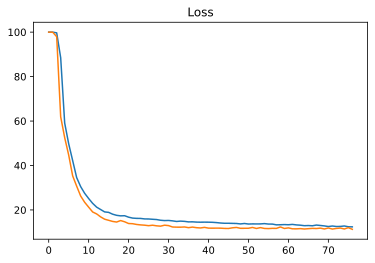

In [196]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [197]:
model_multi_2.load_weights('working/best_model_multi_2.hdf5')
model_multi_2.save('working/multi_2.hdf5')
# for kagle:
# model_multi_2.load_weights('../working/best_model_multi_2.hdf5')
# model_multi_2.save('../working/multi_2.hdf5')

In [198]:
test_predict_nn3 = model_multi_2.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.29%


In [69]:
sub_predict_nn3 = model_multi_2.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

#### **Итоги по этапу 8**:
* Результат улучшился до 11.29%
* Использовалась токенизация, а также удаление цифр, лишиних слов и символов
* Я пробовал удалять отдельные английские буквы, но, похоже, это является важной частью обозначения моделей, поэтому я окончательно оставил их
* Я пробовал разобраться с BERT, но это требует дополнительного времени. Я понимаю, что возможности BERT позволяют даже на более сложные задачи, но пока еще не знаю, как практически эту сеть использовать. Оставим на будущее

# Stage 9: Добавляем картинки (Model NN4)

Загрузим фотографии автомобилей, чтобы улучшить предсказания нашей модели, убедимся, что данные погрузились корректно. Данные хранятся в колонке sell_id

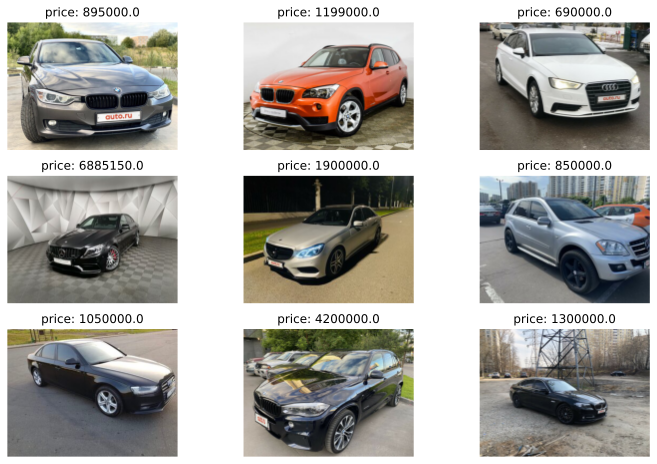

In [70]:
# Версия для jupyter/colab
# Выведем 9 случайных картинок
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open('img/img/' + str(path) + '.jpg')
    # for kagle:
    # im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Фотографии загрузились, теперь можно загрузить изображения размером 320Х240

In [71]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread('img/img/' + str(sell_id) + '.jpg')
        # for kagle:
        # image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


#### **Albumentations**

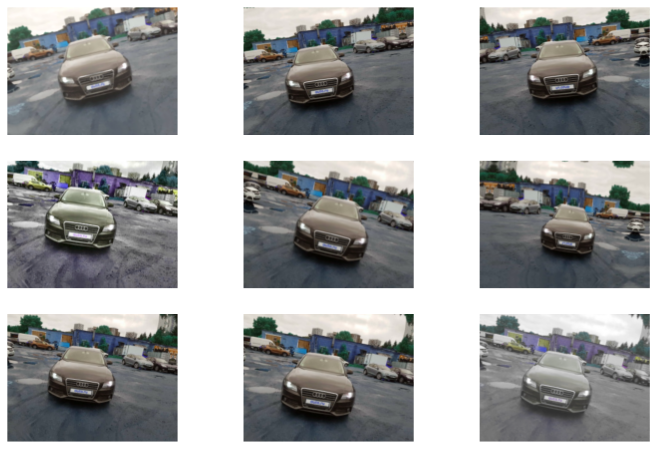

In [55]:
# Первый вариант аугументации
augmentation_1 = Compose([
    HorizontalFlip(p=0.3),
    GaussianBlur(p=0.05),
    OneOf([
#         MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
#         Blur(blur_limit=3, p=0.2),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, 
                     scale_limit=0.1, 
                     rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation_1(image = images_train[10])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

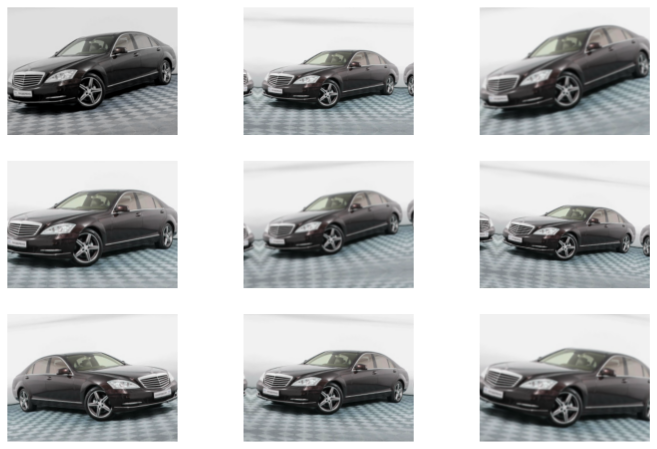

In [77]:
# Второй вариант аугументации
augmentation_2 = Compose([
    HorizontalFlip(p=0.2),
    GaussianBlur(p=0.5),
    MotionBlur(p=0.2),
    ShiftScaleRotate(shift_limit=0.04, 
                     scale_limit=0.2, 
                     rotate_limit=10, 
                     p=0.8),
    HueSaturationValue(p=0.1)
])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation_2(image = images_train[133])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

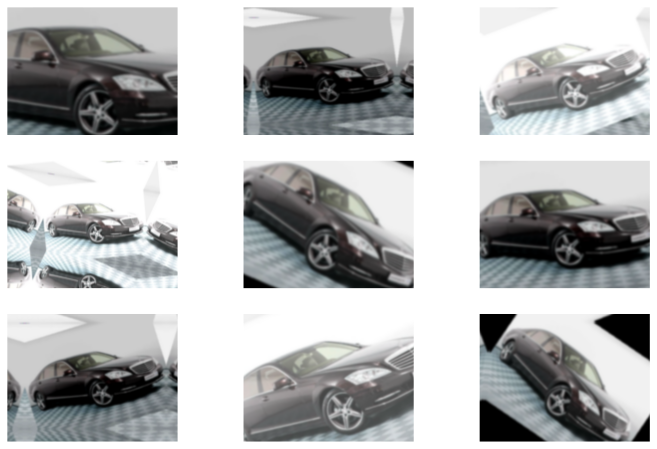

In [74]:
# Третий вариант аугументации
augmentation_3 = Compose([
    HorizontalFlip(p=1),
    RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3 ,p=0.5),
    Rotate(limit=30, 
           interpolation=1, 
           border_mode=5,
           p=1),
    GaussianBlur(p=2),
    MotionBlur(p=0.1),
    ShiftScaleRotate(shift_limit=0.04, 
                     scale_limit=0.8, 
                     rotate_limit=10, 
                     p=0.8),
    HueSaturationValue(p=0.1)
])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation_3(image = images_train[133])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Загрузка данных: tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является tf.data.Dataset. Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости (lazy evaluation).

tf.data.Dataset.from_tensor_slices(data) - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если data = (np.zeros((128, 256, 256)), np.zeros(128)), то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

dataset2 = dataset1.map(func) - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: dataset2 = dataset.map(lambda img, label: img).
dataset2 = dataset1.batch(8) - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

dataset.__iter__() - превращение датасета в итератор, из которого можно получать элементы методом .__next__(). Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

dataset2 = dataset1.repeat(X) - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (.map()) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в .map(). .

In [78]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(data.description)
tokenize.fit_on_texts(data.description_prep_lem)

In [79]:
def process_image(image):
    # используем выбранный вариант аугументации
    return augmentation_2(image = image.numpy())['image']

def tokenize_(descriptions_prep_lem):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions_prep_lem), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description_prep_lem.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description_prep_lem.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description_prep_lem.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

2022-02-09 09:17:27.665828: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-02-09 09:17:29.066830: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-02-09 09:17:31.329549: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-02-09 09:17:32.494178: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-09 09:17:32.790093: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [1]:
# data.description_prep_lem.iloc[X_train.index]

In [2]:
# train_dataset

# Step 10: Использование внешних сетей для обработки изображения (Model NN4)

#### **Строим сверточную сеть для анализа изображений без "головы"**

#### **Без обучения**

In [82]:
tf.keras.backend.clear_session()

In [83]:
# Загрузим модель без головы
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

43950080/43941136 [==============================] - 0s 0us/step


In [84]:
efficientnet_model.trainable = False

In [85]:
base_eff_B3_model  = Sequential()
base_eff_B3_model.add(efficientnet_model)
base_eff_B3_model.add(L.GlobalAveragePooling2D(),)

In [86]:
base_eff_B3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 8, 10, 1536)       10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
Total params: 10,783,535
Trainable params: 0
Non-trainable params: 10,783,535
_________________________________________________________________


In [87]:
len(base_eff_B3_model.trainable_variables)

0

Добавляем архитекутру с этапа обработки текста

In [88]:
# Вставляем NLP
model_nlp_2 = Sequential()
model_nlp_2.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp_2.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp_2.add(L.LayerNormalization())
model_nlp_2.add(L.LSTM(256, return_sequences=True))
model_nlp_2.add(L.Dropout(0.5))
model_nlp_2.add(L.Dense(128, activation="sigmoid"))
model_nlp_2.add(L.Dropout(0.5))
model_nlp_2.add(L.LSTM(128,))
model_nlp_2.add(L.Dropout(0.25))
model_nlp_2.add(L.Dense(64, activation="relu"))
model_nlp_2.add(L.Dropout(0.25))

In [89]:
# Вставляем еще раз выработанную табличную сеть
model_mlp_2 = Sequential()
model_mlp_2.add(L.Dense(512, input_dim=X_train.shape[1], 
                  activation="sigmoid",
                  kernel_regularizer=regularizers.l2(l2=1e-6)
                 ))
model_mlp_2.add(L.Dropout(0.5))
model_mlp_2.add(L.Dense(256, kernel_regularizer=regularizers.l2(l2=1e-6),
                  activation="relu"))
model_mlp_2.add(L.Dropout(0.5))
model_mlp_2.add(L.Dense(256, kernel_regularizer=regularizers.l2(l2=0.00001), 
                  activation="relu"))
model_mlp_2.add(L.Dropout(0.25))
model_mlp_2.add(L.Dense(32, kernel_regularizer=regularizers.l2(l2=0.001), 
                  activation="relu"))
# model.add(L.Dropout(0.25))
model_mlp_2.add(L.Dense(1, activation="linear"))

In [90]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([base_eff_B3_model.output, 
                               model_mlp_2.output, 
                               model_nlp_2.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model_nn4 = Model(inputs=[base_eff_B3_model.input, 
                          model_mlp_2.input, 
                          model_nlp_2.input], outputs=head)
model_nn4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4290304     seq_description[0][0]            
__________________________________________________________________________________________________
dense_2_input (InputLayer)      [(None, 371)]        0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 256, 256)     512         embedding[0][0]                  
______________________________________________________________________________________________

In [91]:
# укажем используемый оптимизатор и начальную скорость обучения
optimizer = tf.keras.optimizers.Adam(0.005)
# компиляция модели
model_nn4.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [92]:
checkpoint = ModelCheckpoint('working/best_model_nn4.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')

# checkpoint = ModelCheckpoint('../working/best_model_nn4.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=15, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [93]:
history = model_nn4.fit(train_dataset.batch(30),
                    epochs=300,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

2022-02-08 11:10:01.173721: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-02-08 11:10:01.963241: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.


Epoch 1/300


2022-02-08 11:10:14.647332: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


190/190 [==============================] - 58s 217ms/step - loss: 46.4083 - MAPE: 46.3554 - val_loss: 20.9402 - val_MAPE: 20.8641


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
190/190 [==============================] - 38s 201ms/step - loss: 19.8829 - MAPE: 19.7949 - val_loss: 15.3631 - val_MAPE: 15.2669
Epoch 3/300
190/190 [==============================] - 38s 201ms/step - loss: 17.2526 - MAPE: 17.1536 - val_loss: 14.0905 - val_MAPE: 13.9863
Epoch 4/300
190/190 [==============================] - 38s 202ms/step - loss: 16.0234 - MAPE: 15.9195 - val_loss: 13.0783 - val_MAPE: 12.9740
Epoch 5/300
190/190 [==============================] - 39s 203ms/step - loss: 15.5697 - MAPE: 15.4645 - val_loss: 13.3197 - val_MAPE: 13.2110
Epoch 6/300
190/190 [==============================] - 38s 201ms/step - loss: 15.2489 - MAPE: 15.1426 - val_loss: 13.0514 - val_MAPE: 12.9448
Epoch 7/300
190/190 [==============================] - 38s 202ms/step - loss: 15.0686 - MAPE: 14.9608 - val_loss: 12.2995 - val_MAPE: 12.1896
Epoch 8/300
190/190 [==============================] - 38s 201ms/step - loss: 14.4549 - MAPE: 14.3467 - val_loss: 12.3157 - val_MAPE: 12.2066
Epoch 

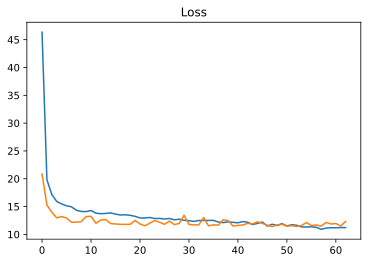

In [94]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [95]:
model_nn4.load_weights('working/best_model_nn4.hdf5')
model_nn4.save('working/model_nn4.hdf5')
# # For kagle
# model_nn4.load_weights('../working/best_model_nn4.hdf5')
# model_nn4.save('../working/model_nn4.hdf5')

In [96]:
test_predict_nn4 = model_nn4.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn4[:,0]))*100:0.2f}%")

TEST mape: 12.33%


In [ ]:
sub_predict_nn4 = model_nn4.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn4[:,0]
sample_submission.to_csv('nn4_submission.csv', index=False)

#### **Итоги по этапу 10**
* Сеть с ипользованием необучеямой внешней сети для определения изображений показала себя хуже, чем настроенная сеть с NLP
* На этом этаме можно былло потренироваться, чтобы найти оптимальный вариент аугументации
* На следующем этапе буду размораживать внешние слои, чтобы попытаться улучшить результат

# Stage 11: Finetuning (Model NN5)

In [82]:
tf.keras.backend.clear_session()

In [83]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

43950080/43941136 [==============================] - 0s 0us/step


In [84]:
# Сделаем внешнюю модель обучаеимой
efficientnet_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(efficientnet_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [85]:
# Строим модель
fine_tune_B3_model  = Sequential()
fine_tune_B3_model.add(efficientnet_model)
fine_tune_B3_model.add(L.GlobalAveragePooling2D(),)

In [86]:
# Вставляем адаптированную табличную сеть для использования в multiinput
model_tabular = Sequential()
model_tabular.add(L.Dense(512, input_dim=X_train.shape[1], 
#                   activation="sigmoid",
                  activation='relu',
                  kernel_regularizer=regularizers.l2(l2=1e-5),
                  bias_regularizer=regularizers.l2(l2=0.01),
                 ))
model_tabular.add(L.Dropout(0.5))
model_tabular.add(L.Dense(256, 
                  activation="relu"))
model_tabular.add(L.Dropout(0.5))
model_tabular.add(L.Dense(256, 
                  activation="relu"))
model_tabular.add(L.Dropout(0.25))
model_tabular.add(L.Dropout(0.25))
model_tabular.add(L.Dense(1, activation="linear"))

In [87]:
# Вставляем NLP
model_nlp_last = Sequential()
model_nlp_last.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp_last.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp_last.add(L.LayerNormalization())
model_nlp_last.add(L.LSTM(256, return_sequences=True))
model_nlp_last.add(L.Dropout(0.5))
model_nlp_last.add(L.Dense(128, activation="sigmoid"))
model_nlp_last.add(L.Dropout(0.5))
model_nlp_last.add(L.LSTM(128,))
model_nlp_last.add(L.Dropout(0.25))
model_nlp_last.add(L.Dense(64, activation="relu"))
model_nlp_last.add(L.Dropout(0.25))

In [88]:
fine_tune_B3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 8, 10, 1536)       10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
Total params: 10,783,535
Trainable params: 9,838,542
Non-trainable params: 944,993
_________________________________________________________________


In [89]:
#объединяем выходы трех нейросетей
combinedInput_5 = L.concatenate([fine_tune_B3_model.output, 
                               model_tabular.output, 
                               model_nlp_last.output])

# being our regression head
head_5 = L.Dense(256, activation="relu")(combinedInput_5)
head_5 = L.Dense(1,)(head_5)

model_nn5 = Model(inputs=[fine_tune_B3_model.input, 
                          model_tabular.input, 
                          model_nlp_last.input], outputs=head_5)
model_nn5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4290304     seq_description[0][0]            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 371)]        0                                            
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 256, 256)     512         embedding[0][0]                  
______________________________________________________________________________________________

______
_______

In [167]:
# укажем используемый оптимизатор 
optimizer = tf.keras.optimizers.Adam(0.001)

# # Альтернативынй оптимизатор c InverseTimeDecay
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#     initial_learning_rate =0.01, 
#     decay_steps = 1000, 
#     decay_rate = 0.9, 
#     staircase=False, 
#     name=None)

# # компиляция модели
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Вариант с ExponentalDecay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

# # компиляция модели
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# компиляция модели
model_nn5.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [168]:
checkpoint = ModelCheckpoint('../working/best_model_nn5.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
# for kagle
# checkpoint = ModelCheckpoint('../working/best_model_nn5.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=15, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [169]:
history = model_nn5.fit(train_dataset.batch(30),
                    epochs=300,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/300
190/190 [==============================] - 89s 387ms/step - loss: 77.0558 - MAPE: 77.0226 - val_loss: 79.2511 - val_MAPE: 79.1815
Epoch 2/300
190/190 [==============================] - 70s 367ms/step - loss: 32.4176 - MAPE: 32.3673 - val_loss: 23.6224 - val_MAPE: 23.5811
Epoch 3/300
190/190 [==============================] - 69s 365ms/step - loss: 23.6303 - MAPE: 23.5922 - val_loss: 18.5515 - val_MAPE: 18.5167
Epoch 4/300
190/190 [==============================] - 70s 368ms/step - loss: 20.3529 - MAPE: 20.3205 - val_loss: 16.3715 - val_MAPE: 16.3403
Epoch 5/300
190/190 [==============================] - 69s 365ms/step - loss: 18.9246 - MAPE: 18.8940 - val_loss: 15.5303 - val_MAPE: 15.4989
Epoch 6/300
190/190 [==============================] - 69s 364ms/step - loss: 18.0834 - MAPE: 18.0520 - val_loss: 14.5875 - val_MAPE: 14.5551
Epoch 7/300
190/190 [==============================] - 70s 367ms/step - loss: 17.0972 - MAPE: 17.0641 - val_loss: 14.0354 - val_MAPE: 14.0012
Epoch 

In [170]:
test_predict_nn5 = model_nn5.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn5[:,0]))*100:0.2f}%")

TEST mape: 11.10%


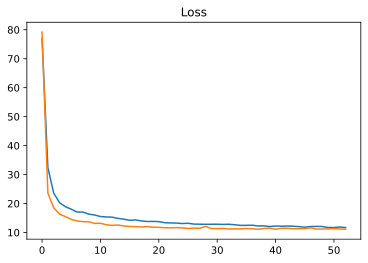

In [171]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [172]:
model_nn5.load_weights('working/best_model_nn5.hdf5')
model_nn5.save('working/model_nn5.hdf5')
# For kagle
# model_nn5.load_weights('../working/best_model_nn5.hdf5')
# model_nn5.save('../working/model_nn5.hdf5')

In [260]:
sub_predict_nn5 = model_nn5.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn5[:,0]
sample_submission.to_csv('nn5_submission.csv', index=False)

#### **Итоги по этапу 11**
* Была выбрана сеть EfficientNetB3EfficientNetB3, потому что именно она дала самые лучшие показатели в предыдущем проекте по классификации фотографий
* Я экспериментировал с различными настройками оптимизаторов, оптимальным оказался  Adam с learning_rate=0.001. Оптимизатор с изменяющим значением  learning rate показал себя слегка хуже. Возможно, при более длительной настройке, удалось бы достичь лучшего результата. Однозначно использование графика изменения learning rate имеет большие возможности, поэтому я оставил в коде, чтобы можно было использовать, как один из вариантов настройки работы модели
* Требовалось адаптировать табличную сеть, чтобы результаты совместной работы с иными сетями улучшались
* Сочетание трех сетей дало наилучший результат, а также позволило использовать признаки, которые ранее пропускались: тектввое описание и фотографии. А при покупке автомобилей изображение и описание имеют большое значение

# Stage 12: Blend

#### **Blend двух моделей**

В качестве конечного результата используем комбинацию из результатов предсказаний некоторых предыдущих моделей:

In [201]:
test_predict_nn5 = model_nn5.predict(test_dataset.batch(30))

In [232]:
# 
blend_predict = (test_predict_catboost + test_predict_nn5[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.66%


In [261]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn5[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

Общий результат 10.66%

__________
______

# Общие выводы

* Этот проект соединил в одно целое использование алгритмов машинного обучения и нескольких видов нейросетей
* Соединение нескольких нейросетей в одну мультисеть - это сложная архииектура с большим количеством параметров, настройка которых влияет на общий результат
* Оптимизация результата требует соответсвующей организации времени и этапов работы. Экспериментировать нужно много, поэтому важно регистировать шаги, чтобы знать, какой шаг нужно отменить, чтобы не ухудшить результат. Важно также делать небольшие изменения, чтобы понимать, что именно повлияло на результат
* Один из самых сильных факторов для всех алгоритмов ML и DL - это learning rate. Экспериментирование с ним помогало улучшать результат, а также скорость достижения результата
* Количество слов нейросети и из размер - это еще одно поле большого числа комбинаций оптимизации.
* В данном задании отлично себя показала функция активации Relu, немного хуже Sigmoid. 
* Даже используя сложные алгоритмы важно не забывать об основах полдтовления данных. Преобразования с целью создания новых призаков дают положительные эффекты
* В целом удалось достичь улучшения результата, благодаря использованию нейросетей, но, думаю, что изучение архитектуры нейросетей требует еще более глубокого изучения 